In [1]:
# !pip install setuptools wheel pip --upgrade
!pip install super-gradients

  Obtaining dependency information for super-gradients from https://files.pythonhosted.org/packages/4b/07/ab831d8e0763c17a869b875aadbe411a67fb469db26f0f689aeac4e3e6ee/super_gradients-3.6.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.3 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.5 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for pip-tools>=6.12.1 from https://files

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.model_selection import GroupKFold
from super_gradients.training import dataloaders
from super_gradients.training import Trainer, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2024-02-07 04:36:10] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-02-07 04:36:11] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-07 04:36:28] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-07 04:36:28] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-07 04:36:28] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-02-07 04:36:28] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2024-02-07 04:36:28] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx required but not found
[2024-02-07 04:36:28] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2024-02-07 04:36:28] WARNING - env_sanity_check.py - Failed to verify installed packages: omegaconf required but not found
[2024-02-07 04:36:28] WARNING - env_sanity_check.py - Failed to verify installed packages: onnxruntime required but not found
[2024-02-07 04:36:28] WAR

In [3]:
fold = 4

In [4]:
train_df = pd.read_csv(f'../input/vinbigdata-512-image-dataset/vinbigdata/train.csv')
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


In [5]:
train_df['image_path'] = f'/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/'+train_df.image_id+('.png' if 512!='original' else '.jpg')
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,/kaggle/input/vinbigdata-512-image-dataset/vin...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,/kaggle/input/vinbigdata-512-image-dataset/vin...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/kaggle/input/vinbigdata-512-image-dataset/vin...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/kaggle/input/vinbigdata-512-image-dataset/vin...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,/kaggle/input/vinbigdata-512-image-dataset/vin...
...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200,/kaggle/input/vinbigdata-512-image-dataset/vin...
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430,/kaggle/input/vinbigdata-512-image-dataset/vin...
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040,/kaggle/input/vinbigdata-512-image-dataset/vin...


In [6]:
print(train_df['class_name'].value_counts())
print("Total: ",train_df['class_name'].value_counts().sum()-31818)

class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64
Total:  36096


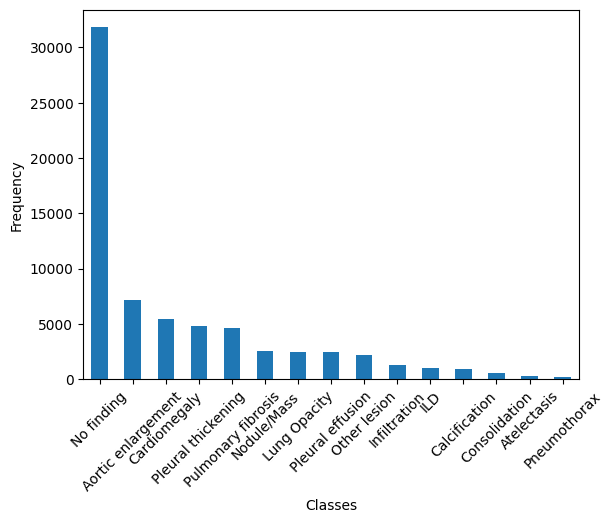

In [7]:
import matplotlib.pyplot as plt
train_df['class_name'].value_counts().plot.bar(rot=45)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [8]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [9]:
#co-ordinates
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.239875,0.721145,0.045950,0.039368,0.001809


In [10]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]#bounding box
y = train_df['class_id']#class
X.shape, y.shape

((36096, 9), (36096,))

In [11]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [12]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.563462,0.686216,0.462500,0.195205,0.090283,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.623915,0.305903,0.150608,0.095833,0.014433,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.309843,0.128581,0.125984,0.024740,0.003117,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.773523,0.472407,0.368053,0.753033,0.277156,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.239875,0.721145,0.045950,0.039368,0.001809,4


In [13]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(3515, 879)

In [14]:
os.makedirs('/kaggle/working/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/val', exist_ok = True)
label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels'
for file in tqdm(train_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/val')

  0%|          | 0/3515 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

In [15]:
dataset_params = {
    'data_dir':'/kaggle/working/vinbigdata',
    'train_images_dir':'/kaggle/working/vinbigdata/images/train',
    'train_labels_dir':'/kaggle/working/vinbigdata/labels/train',
    'val_images_dir':'/kaggle/working/vinbigdata/images/val',
    'val_labels_dir':'/kaggle/working/vinbigdata/labels/val',
    'test_images_dir':'/kaggle/working/vinbigdata/images/val',
    'test_labels_dir':'/kaggle/working/vinbigdata/labels/val',
    'classes': classes
}

In [16]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes'],
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2,
        'shuffle':True
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes'],       
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    },
    
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [17]:
train_data.dataset.transforms

Indexing dataset annotations: 100%|██████████| 879/879 [00:00<00:00, 5467.92it/s]


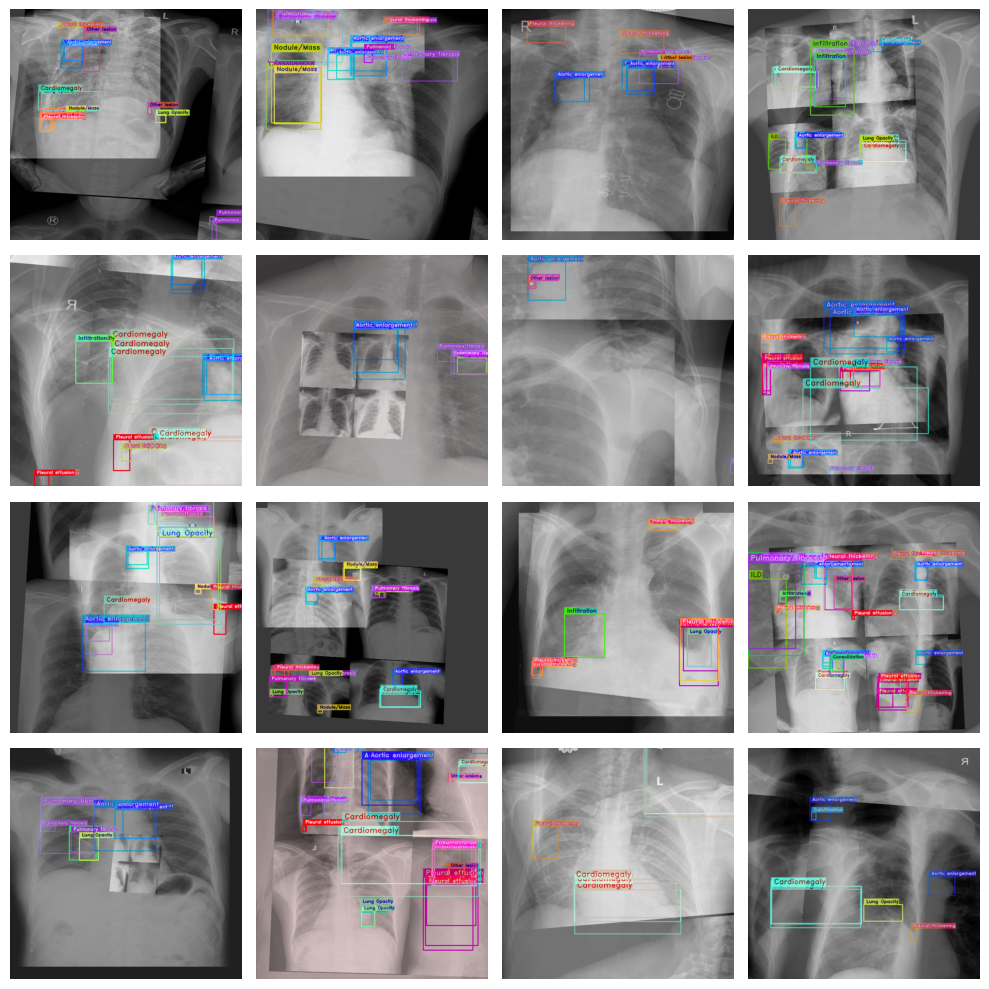

In [18]:
train_data.dataset.plot()

In [19]:
model = models.get('yolo_nas_m', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco")
#                     checkpoint_path="/kaggle/working/checkpoints/version_1/RUN_20240106_071447_261605/ckpt_best.pth")

[2024-02-07 04:38:21] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:00<00:00, 253MB/s] 
[2024-02-07 04:38:22] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


In [20]:
train_params = {
    "silent_mode":True,
    "average_best_models":True,
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 1e-5,
    "lr_warmup_steps":1000,
    "lr_warmup_epochs": 3,
    "initial_lr": 1e-3,
    "lr_mode": "CosineLRScheduler",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.00001},
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate":1,
    "ema": True,
    "ema_params": {"decay": 0.997, "decay_type": "threshold"},
    "max_epochs": 250,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes'])
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.3,
            top_k_predictions=100,
            calc_best_score_thresholds= True,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.03,
                nms_top_k=512,
                max_predictions=50,
                nms_threshold=0.7,
            )
        )
    ],
   "metric_to_watch": 'mAP@0.50',
    "greater_metric_to_watch_is_better": True
}

In [21]:
# shutil.rmtree('/kaggle/working/checkpoints1')

In [22]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='version_1', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
trainer.train(model=model,
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2024-02-07 04:38:23] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240207_043823_117207`
[2024-02-07 04:38:23] INFO - sg_trainer.py - Checkpoints directory: checkpoints/version_1/RUN_20240207_043823_117207
[2024-02-07 04:38:23] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/version_1/RUN_20240207_043823_117207/console_Feb07_04_38_23.txt


[2024-02-07 04:38:23] WARNING - callbacks.py - Number of warmup steps (1000) is greater than number of steps in epoch (219). Warmup steps will be capped to number of steps in epoch to avoid interfering with any pre-epoch LR schedulers.
[2024-02-07 04:38:26] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3515       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         219        (len(train_loader))
    - Gradient updates per epoch:   219        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_M  (51.14M parameters, 51.14M optimized)
   

In [24]:
import os

# Define the path to the folder containing your files
folder_path = "/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207"

# Get a list of files in the folder
files = os.listdir(folder_path)

# Print the links
for file in files:
    file_path = os.path.join(folder_path, file)
    print(file_path)

/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/average_model.pth
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/experiment_logs_Feb07_04_38_23.txt
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/ckpt_best.pth
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/events.out.tfevents.1707314167.b9829859d68f.42.1
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/logs_Feb07_04_38_23.txt
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/ckpt_latest.pth
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/averaging_snapshots.pkl
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/events.out.tfevents.1707280703.b9829859d68f.42.0
/kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/console_Feb07_04_38_23.txt


In [26]:
!zip -r yolonasm.zip /kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/events.out.tfevents.1707314167.b9829859d68f.42.1

  adding: kaggle/working/checkpoints/version_1/RUN_20240207_043823_117207/events.out.tfevents.1707314167.b9829859d68f.42.1 (deflated 43%)


In [27]:
from IPython.display import FileLink
FileLink(r'yolonasm.zip')

/kaggle/working/yolonasm.zip